In [18]:
import pandas as pd
import re

In [19]:
# Read in data
train = pd.read_csv('data/train.csv')
val = pd.read_csv('data/val.csv')

### Data Cleaning ###


In [24]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# Helper function for cleaning text
def clean_html(text):
    if pd.isna(text):
        return text
    # Remove HTML tags
    clean = re.sub(r'<.*?>', '', str(text))
    # Remove extra whitespaces
    clean = re.sub(r'\s+', ' ', clean).strip()
    # Replace HTML entities
    clean = re.sub(r'&amp;', '&', clean)
    clean = re.sub(r'&lt;', '<', clean)
    clean = re.sub(r'&gt;', '>', clean)
    clean = re.sub(r'&quot;|&#34;', '"', clean)
    clean = re.sub(r'&apos;|&#39;', "'", clean)
    return clean

# Data Cleaning
train['snip'] = train['snip'].apply(clean_html)
val['snip']   = val['snip'].apply(clean_html)

X_train = train['snip']
X_val = val['snip']
y_train = train['channel']
y_val   = val['channel']

# print(train['channel'].unique())

# Label encode once
le = LabelEncoder().fit(y_train)
y_train= le.transform(y_train)
y_val  = le.transform(y_val)
n_classes   = len(le.classes_)

# Class balancing via uniform oversampling
df_train = pd.DataFrame({'snip': train['snip'], 'y': y_train})
ros = RandomOverSampler()
df_res, y_res = ros.fit_resample(df_train[['snip']], df_train['y'])

X_train = df_res['snip']
y_train = y_res

### 3.2 Part A ###

In [25]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

token_pattern = r"(?u)\b\w+\b|[¿¡_$£€₽﷼¥₹₩₱]|[^\w\s]"

# Count Vectorized features
count_vect = CountVectorizer(token_pattern= token_pattern, lowercase=True)
X_train_count = count_vect.fit_transform(X_train)
X_val_count   = count_vect.transform(X_val)

# Tfidf features
tfidf_vect = TfidfVectorizer(token_pattern= token_pattern, lowercase=True)
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_val_tfidf   = tfidf_vect.transform(X_val)

print(X_train_tfidf.shape)
print(X_train_count.shape)

# Baseline logistic regressor
lr = LogisticRegression(max_iter=1000)

# Raw counts representation
lr.fit(X_train_count, y_train)
pred_count = lr.predict(X_val_count)
print("CountVectorizer results:")
print(accuracy_score(y_val, pred_count))


# Tfidf Representation
lr.fit(X_train_tfidf, y_train)
pred_tfidf = lr.predict(X_val_tfidf)
print("TfidfVectorizer results:")
print(accuracy_score(y_val, pred_tfidf))



(84475, 66732)
(84475, 66732)
CountVectorizer results:
0.5867061533399145
TfidfVectorizer results:
0.6225732148733136


In [12]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score


svc = LinearSVC(C = 1, max_iter= 10000)


svc.fit(X_train_tfidf, y_train)

# evaluate on your validation set
y_pred = svc.predict(X_val_tfidf)
print("Validation accuracy:", accuracy_score(y_val, y_pred))

Validation accuracy: 0.6199407699901284


### 3.3.1 B1 ###


In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

models = {
    'RandomForest' : RandomForestClassifier(n_jobs=-1),
    # 'GradientBoosting' : GradientBoostingClassifier(learning_rate= 0.1),
    # 'KNeighbors' : KNeighborsClassifier(n_neighbors= n_classes),
    'SVM (RBF)' : SVC(kernel='rbf'),
    'SVM (Linear)' : SVC(kernel='linear'),
    'MLP' : MLPClassifier(activation= "relu", solver = "adam", max_iter=200, batch_size=512)
}

results = {}
for name, clf in models.items():
    clf.fit(X_train_tfidf, y_train)
    preds = clf.predict(X_val_tfidf)
    acc = accuracy_score(y_val, preds)
    results[name] = acc
    print(f"{name:17}  val accuracy = {acc:.4f}")

best_model = max(results, key=results.get)
print(f"\nbest model: {best_model} (accuracy = {results[best_model]:.4f})")

RandomForest       val accuracy = 0.4995
SVM (RBF)          val accuracy = 0.5999
SVM (Linear)       val accuracy = 0.6371
MLP                val accuracy = 0.6374

best model: MLP (accuracy = 0.6374)


/Users/jarayliu/Desktop/Harvard-College/S25/CS 181/cs181-s25-homeworks/practical/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


### CFVS SVD Dimensionality Reduction ###

4349
6597


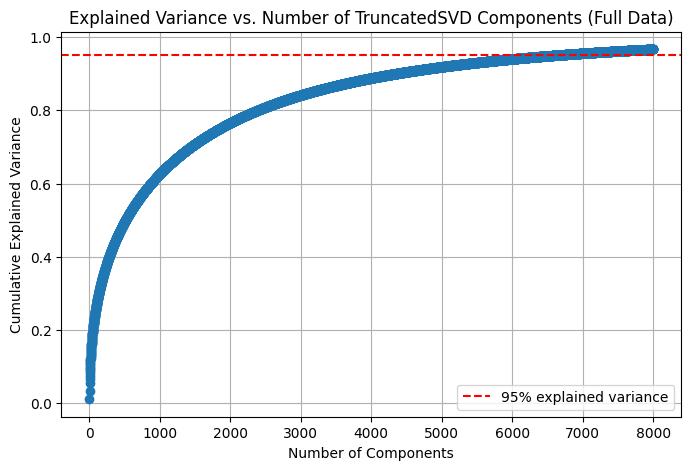

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Set a max number of components to try — this must be < min(n_samples, n_features)
max_components = min(8000, X_train_tfidf.shape[1])

# Fit TruncatedSVD on full sparse matrix
svd = TruncatedSVD(n_components=max_components)
svd.fit(X_train_tfidf)

# Cumulative explained variance
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

# Find the number of components needed to explain 90% and 95% of the variance
n_components_90 = np.searchsorted(cumulative_variance, 0.90) + 1
n_components_95 = np.searchsorted(cumulative_variance, 0.95) + 1

print(n_components_90)
print(n_components_95)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% explained variance')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of TruncatedSVD Components (Full Data)")
plt.grid(True)
plt.legend()
plt.show()

### Other Dimensionality Reduction Techniques ###

In [27]:
from sklearn.decomposition import TruncatedSVD

# Reduce TF–IDF dimensionality
svd = TruncatedSVD(n_components=n_components_95)
X_train_svd1 = svd.fit_transform(X_train_tfidf)
X_val_svd1   = svd.transform(X_val_tfidf)

# Convert to float64
X_train_svd = X_train_svd1.astype('float64')
X_val_svd = X_val_svd1.astype('float64')

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

# Reduce TF–IDF dimensionality using supervised feature selection
selector = SelectKBest(score_func=chi2, k=8233)
X_train_sel = selector.fit_transform(X_train_tfidf, y_train)
X_val_sel   = selector.transform(X_val_tfidf)

X_train_Ksel = X_train_sel.astype('float64').toarray()
X_val_Ksel   = X_val_sel.astype('float64').toarray()

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

# SVD -> LDA to improve stability since LDA reduces to AT MOST n_classes - 1 features
X_train_lda = lda.fit_transform(X_train_svd, y_train).astype('float64')
X_val_lda   = lda.transform(X_val_svd).astype('float64')

print(f'New shape after LDA: {X_train_lda.shape}')


New shape after LDA: (84475, 30)


In [ ]:
from sklearn.cross_decomposition import PLSRegression

# Make TF-IDF dense (if not already)
X_train_dense = X_train_tfidf.toarray().astype('float32')
X_val_dense   = X_val_tfidf.toarray().astype('float32')

# Fit PLS model
n_components = 300  # or whatever number you choose
pls = PLSRegression(n_components=n_components)
pls.fit(X_train_dense, y_train)

# Transform data
X_train_pls = pls.transform(X_train_dense)
X_val_pls   = pls.transform(X_val_dense)

print(f"X_train_pls shape: {X_train_pls.shape}")
print(f"X_val_pls shape: {X_val_pls.shape}")


### 3.3.2. B2 Neural Net Classifier ###

Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.1251 - loss: 3.2760 - val_accuracy: 0.3676 - val_loss: 2.9428
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5157 - loss: 2.4016 - val_accuracy: 0.5058 - val_loss: 2.5139
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7566 - loss: 1.6701 - val_accuracy: 0.5624 - val_loss: 2.0970
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8474 - loss: 1.1334 - val_accuracy: 0.5870 - val_loss: 1.7852
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8864 - loss: 0.7908 - val_accuracy: 0.5946 - val_loss: 1.5824
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9075 - loss: 0.5814 - val_accuracy: 0.6038 - val_loss: 1.4563
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9183 - loss: 0.4569 - val_accuracy: 0.6124 - val_loss: 1.3755
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9301 - loss: 0.3668 -

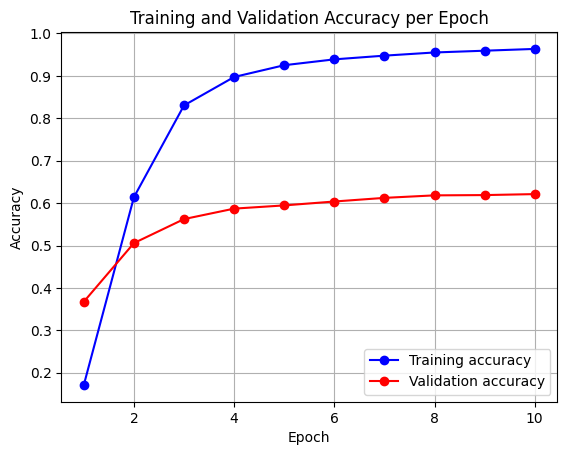

165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
Train accuracy (computed): 0.9747
Validation accuracy (computed): 0.6213
Class index mapping:
  0 -> 1TV
  1 -> ALJAZ
  2 -> BBCNEWS
  3 -> BELARUSTV
  4 -> BLOOMBERG
  5 -> CNBC
  6 -> CNNW
  7 -> COM
  8 -> CSPAN
  9 -> CSPAN2
  10 -> CSPAN3
  11 -> DW
  12 -> FBC
  13 -> FOXNEWSW
  14 -> GBN
  15 -> KDTV
  16 -> KGO
  17 -> KNTV
  18 -> KPIX
  19 -> KQED
  20 -> KRON
  21 -> KSTS
  22 -> KTVU
  23 -> LINKTV
  24 -> MSNBCW
  25 -> NTV
  26 -> PRESSTV
  27 -> RT
  28 -> RUSSIA1
  29 -> RUSSIA24
  30 -> SFGTV

Train classification report:
              precision    recall  f1-score   support

         1TV       1.00      1.00      1.00      2725
       ALJAZ       1.00      1.00      1.00      2725
     BBCNEWS       1.00      0.99      0.99      2725
   BELARUSTV       1.00      1.00      1.00      2725
   BLOOMBERG       0.99      0.98      0.99      2725
        CNBC       0.97      0.97      0.97     

/Users/jarayliu/Desktop/Harvard-College/S25/CS 181/cs181-s25-homeworks/practical/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jarayliu/Desktop/Harvard-College/S25/CS 181/cs181-s25-homeworks/practical/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jarayliu/Desktop/Harvard-College/S25/CS 181/cs181-s25-homeworks/practical/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report


# Build tf.data pipelines
batch_size = 512
train_ds = tf.data.Dataset.from_tensor_slices((X_train_svd, y_train)) \
    .shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val_svd, y_val)) \
    .batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Define and compile your MLP
model = keras.Sequential([
    layers.Input(shape=(X_train_svd.shape[1],)),
    layers.Dense(256, activation='gelu'),
    layers.LayerNormalization(),
    layers.Dropout(0.65),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback: stop if val_accuracy doesn’t improve for 3 epochs
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Train with early stopping
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=[early_stop]
)

# Determine how many epochs were run
epochs_run = len(history.history['accuracy'])
print(f"Training stopped after {epochs_run} epochs (best val_accuracy)")

# Evaluate final model
loss, acc = model.evaluate(val_ds, verbose=0)
print(f'Validation accuracy: {acc:.4f}')

# find the epoch (1-indexed) with highest val_accuracy
val_acc_history = history.history['val_accuracy']
best_epoch = int(np.argmax(val_acc_history)) + 1
print(f"Best validation accuracy of {val_acc_history[best_epoch-1]:.4f} at epoch {best_epoch}")

# now plot ONLY up to that best epoch
epochs = range(1, best_epoch + 1)
train_acc = history.history['accuracy'][:best_epoch]
val_acc   = history.history['val_accuracy'][:best_epoch]

plt.figure()
plt.plot(epochs, train_acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Build an un-shuffled train dataset purely for evaluation
eval_train_ds = tf.data.Dataset.from_tensor_slices((X_train_svd, y_train)) \
    .batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Get predicted probabilities and convert to class labels
train_probs = model.predict(eval_train_ds)
val_probs   = model.predict(val_ds)

train_pred = np.argmax(train_probs, axis=1)
val_pred   = np.argmax(val_probs, axis=1)

# Overall accuracies
train_acc = accuracy_score(y_train, train_pred)
val_acc   = accuracy_score(y_val, val_pred)

print(f'Train accuracy (computed): {train_acc:.4f}')
print(f'Validation accuracy (computed): {val_acc:.4f}')

# 1. Sanity check: print the mapping from integer label → class name
print("Class index mapping:")
for idx, cls in enumerate(le.classes_):
    print(f"  {idx} -> {cls}")

# 3. Classification reports with string labels
print("\nTrain classification report:")
print(classification_report(
    y_train,
    train_pred,
    labels=list(range(len(le.classes_))),
    target_names=le.classes_
))

print("Validation classification report:")
print(classification_report(
    y_val,
    val_pred,
    labels=list(range(len(le.classes_))),
    target_names=le.classes_
))

### MLP Classifier Hyperparameter Tuning ###

In [16]:
import itertools
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

batch_size = 512

feature_sets = {
    'svd'     : (X_train_svd,    X_val_svd),
    'selectk' : (X_train_Ksel,    X_val_Ksel),
    'svd_lda' : (X_train_lda, X_val_lda),
}

# MLP builder
def build_model(input_dim, units, dropout_rate, learning_rate):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(units, activation='gelu'),
        layers.LayerNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Hyperparameter grid
param_grid = {
    'units'         : [64, 128, 256, 512, 1024],
    'dropout_rate'  : [0.15, 0.3, 0.45, 0.55, 0.65],
    'learning_rate' : [1e-4, 3e-4, 1e-3, 3e-3, 1e-2],
}

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

best_acc = 0.0
best_cfg = None

# Grid-search over feature-sets and MLP hyperparams
for name, (X_tr, X_val) in feature_sets.items():
    train_ds = tf.data.Dataset.from_tensor_slices((X_tr, y_train)) \
                    .shuffle(10000) \
                    .batch(batch_size) \
                    .prefetch(tf.data.AUTOTUNE)
    val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)) \
                    .batch(batch_size) \
                    .prefetch(tf.data.AUTOTUNE)

    input_dim = X_tr.shape[1]

    # initialize per-feature-set trackers
    best_acc_fs = 0.0
    best_cfg_fs = None

    for units, dropout_rate, lr in itertools.product(param_grid['units'], param_grid['dropout_rate'], param_grid['learning_rate']):
        K.clear_session()
        model = build_model(input_dim, units, dropout_rate, lr)
        model.fit(
            train_ds,
            epochs=100,
            validation_data=val_ds,
            callbacks=[early_stopping],
            verbose=0
        )
        loss, acc = model.evaluate(val_ds, verbose=0)
        print(f"{name:7} | units={units}, drop={dropout_rate}, lr={lr:.4f} -> val_acc={acc:.4f}")

        # update global best
        if acc > best_acc:
            best_acc = acc
            best_cfg = {
                'feature_set' : name,
                'units'       : units,
                'dropout_rate': dropout_rate,
                'learning_rate': lr
            }

        # update this feature-set best
        if acc > best_acc_fs:
            best_acc_fs = acc
            best_cfg_fs = {
                'units'       : units,
                'dropout_rate': dropout_rate,
                'learning_rate': lr
            }

    # after exhausting this feature set, print its best
    print(f"\n Best for {name}: {best_cfg_fs}  (validation accuracy={best_acc_fs:.5f})\n")

# finally, print the overall best
print(f"==== GLOBAL BEST ====\n{best_cfg}  (validation accuracy={best_acc:.5f})")



Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 13.
svd     | units=64, drop=0.15, lr=0.0001 -> val_acc=0.5429
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 7.
svd     | units=64, drop=0.15, lr=0.0003 -> val_acc=0.5594
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.
svd     | units=64, drop=0.15, lr=0.0010 -> val_acc=0.5387
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 7.
svd     | units=64, drop=0.15, lr=0.0030 -> val_acc=0.5235
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
svd     | units=64, drop=0.15, lr=0.0100 -> val_acc=0.5173
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 18.
svd     | units=64, drop=0.3, lr=0.0001 -> val_acc=0.5574
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 9.
svd     | units=64, drop=0.3, lr=0.0003 -> val_acc=0.5505
E

### 3.3.2 B2 XGBoost Section ###

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# new XGB instance (baseline)
xgb = XGBClassifier(objective = "multi:softprob", num_classes = n_classes, eval_metric='merror', n_jobs=-1)

# fit on integers
xgb.fit(X_train_tfidf, y_train)

# predict integers, then invert
pred_enc = xgb.predict(X_val_tfidf)
preds    = le.inverse_transform(pred_enc)

print("Validation accuracy:", accuracy_score(y_val, preds))

Validation accuracy: 0.5143139190523198


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


# base parameters before CV
base_params = {
    'objective'          : 'multi:softprob',
    'num_class'          : n_classes,
    'eval_metric'        : 'merror',
    'n_jobs'             : -1,
    # default Group 3 values
    'learning_rate'      : 0.1,
    'n_estimators'       : 100,
    # default Group 2 values
    'subsample'          : 1.0,
    'colsample_bytree'   : 1.0,
}

# GROUP 1: max_depth & min_child_weight
print("Tuning GROUP 1 …")
param_grid_1 = {
    'max_depth'        : [3, 5, 7],
    'min_child_weight' : [1, 3, 5],
}
xgb1 = XGBClassifier(**base_params)
grid1 = GridSearchCV(xgb1, param_grid_1, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid1.fit(X_train_tfidf, y_train)
print("GROUP 1 best:", grid1.best_params_, "CV=", grid1.best_score_)
base_params.update(grid1.best_params_)   # lock them in

# GROUP 2: subsample & colsample_bytree
print("\nTuning GROUP 2 …")
param_grid_2 = {
    'subsample'        : [0.6, 0.8, 1.0],
    'colsample_bytree' : [0.6, 0.8, 1.0],
}
xgb2 = XGBClassifier(**base_params)
grid2 = GridSearchCV(xgb2, param_grid_2, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid2.fit(X_train_tfidf, y_train)
print("GROUP 2 best:", grid2.best_params_, "CV=", grid2.best_score_)
base_params.update(grid2.best_params_)   # lock them in

# GROUP 3: learning_rate & n_estimators
print("\nTuning GROUP 3 …")
param_grid_3 = {
    'learning_rate' : [0.01, 0.1, 0.2],
    'n_estimators'  : [150, 300, 450],
}
xgb3 = XGBClassifier(**base_params)
grid3 = GridSearchCV(xgb3, param_grid_3, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid3.fit(X_train_tfidf, y_train)
print("GROUP 3 best:", grid3.best_params_, "CV=", grid3.best_score_)
base_params.update(grid3.best_params_)   # final set

# FINAL EVALUATION
print("\nTraining final model with all tuned hyperparameters …")
final_xgb = XGBClassifier(**base_params)
final_xgb.fit(X_train_tfidf, y_train)

preds = final_xgb.predict(X_val_tfidf)

print("Validation accuracy:", accuracy_score(y_val, preds))


Tuning GROUP 1 …
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ....................max_depth=3, min_child_weight=5; total time= 2.9min
[CV] END ....................max_depth=3, min_child_weight=5; total time= 2.9min
[CV] END ....................max_depth=3, min_child_weight=5; total time= 3.0min
[CV] END ....................max_depth=3, min_child_weight=3; total time= 3.3min
[CV] END ....................max_depth=3, min_child_weight=3; total time= 3.3min
[CV] END ....................max_depth=3, min_child_weight=3; total time= 3.4min
[CV] END ....................max_depth=3, min_child_weight=1; total time= 4.2min
[CV] END ....................max_depth=3, min_child_weight=1; total time= 4.2min
[CV] END ....................max_depth=3, min_child_weight=1; total time= 4.3min
[CV] END ....................max_depth=5, min_child_weight=1; total time=10.3min
[CV] END ....................max_depth=5, min_child_weight=5; total time= 7.2min
[CV] END ....................max

In [27]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

base_params = {
    'objective'        : 'multi:softprob',
    'num_class'        : len(le.classes_),
    'eval_metric'      : 'merror',
    'n_jobs'           : -1,
    'max_depth'        : 5,
    'min_child_weight' : 3,
    'subsample'        : 1.0,
    'learning_rate'    : 0.1,
    'n_estimators'     : 450,
}

# tune colsample_bytree over five values
colsample_grid = {'colsample_bytree': [0.2, 0.3, 0.4, 0.5, 0.6]}
xgb_col = XGBClassifier(**base_params)
grid_col = GridSearchCV(
    xgb_col,
    colsample_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
grid_col.fit(X_train_tfidf, y_train)
print("Best colsample_bytree:", grid_col.best_params_['colsample_bytree'],
      "CV acc:", grid_col.best_score_)

# lock it in
base_params['colsample_bytree'] = grid_col.best_params_['colsample_bytree']

# search over n_estimators next:
estimators_grid = {'n_estimators': [400, 550, 700, 850, 1000]}
xgb_est = XGBClassifier(**base_params)
grid_est = GridSearchCV(
    xgb_est,
    estimators_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
grid_est.fit(X_train_tfidf, y_train)
print("Best n_estimators:", grid_est.best_params_['n_estimators'],
      "CV acc:", grid_est.best_score_)
base_params['n_estimators'] = grid_est.best_params_['n_estimators']

# final fit with early stopping
final_xgb = XGBClassifier(**base_params, early_stopping_rounds=100)
final_xgb.fit(
    X_train_tfidf, y_train,
    eval_set=[(X_val_tfidf, y_val)],
    verbose=False
)

preds = final_xgb.predict(X_val_tfidf)
print("Validation accuracy:", accuracy_score(y_val, preds))


Fitting 3 folds for each of 5 candidates, totalling 15 fits


python(76334) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76335) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76336) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76337) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76338) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76339) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76340) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76341) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76342) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76343) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76344) Malloc

[CV] END ...............................colsample_bytree=0.2; total time=40.9min
[CV] END ...............................colsample_bytree=0.3; total time=43.2min
[CV] END ...............................colsample_bytree=0.2; total time=43.3min
[CV] END ...............................colsample_bytree=0.2; total time=44.3min
[CV] END ...............................colsample_bytree=0.3; total time=45.2min
[CV] END ...............................colsample_bytree=0.4; total time=45.5min
[CV] END ...............................colsample_bytree=0.3; total time=46.2min
[CV] END ...............................colsample_bytree=0.4; total time=46.9min
[CV] END ...............................colsample_bytree=0.5; total time=47.1min
[CV] END ...............................colsample_bytree=0.4; total time=47.6min
[CV] END ...............................colsample_bytree=0.5; total time=17.7min
[CV] END ...............................colsample_bytree=0.5; total time=16.9min
[CV] END ...................

python(77062) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77063) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77064) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77065) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77066) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77067) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77068) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77069) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77070) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77071) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END ...................................n_estimators=400; total time=25.6min
[CV] END ...................................n_estimators=400; total time=26.9min
[CV] END ...................................n_estimators=400; total time=27.6min
[CV] END ...................................n_estimators=550; total time=32.2min
[CV] END ...................................n_estimators=550; total time=33.9min
[CV] END ...................................n_estimators=550; total time=34.8min
[CV] END ...................................n_estimators=700; total time=37.6min
[CV] END ...................................n_estimators=700; total time=39.2min
[CV] END ...................................n_estimators=700; total time=40.0min
[CV] END ...................................n_estimators=850; total time=41.3min
[CV] END ...................................n_estimators=850; total time=30.4min
[CV] END ...................................n_estimators=850; total time=30.3min
[CV] END ...................

/Users/jarayliu/Desktop/Harvard-College/S25/CS 181/cs181-s25-homeworks/practical/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:15:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


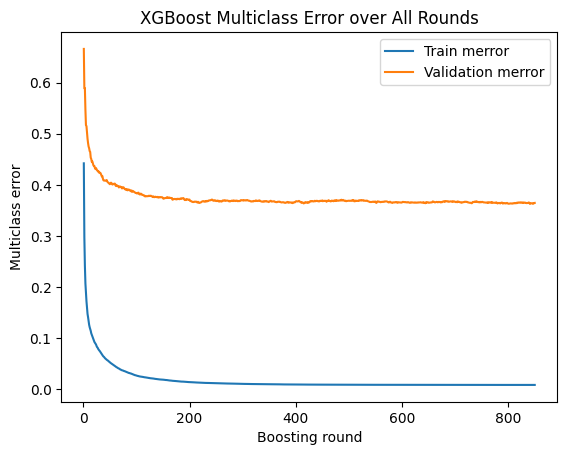

XGB train accuracy: 0.9912281740159811
XGB val accuracy: 0.6354063836788417
XGB train classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2725
           1       1.00      1.00      1.00      2725
           2       1.00      1.00      1.00      2725
           3       1.00      1.00      1.00      2725
           4       1.00      1.00      1.00      2725
           5       1.00      1.00      1.00      2725
           6       1.00      1.00      1.00      2725
           7       1.00      1.00      1.00      2725
           8       0.95      0.93      0.94      2725
           9       0.94      0.85      0.89      2725
          10       0.85      0.95      0.90      2725
          11       1.00      1.00      1.00      2725
          12       1.00      1.00      1.00      2725
          13       1.00      1.00      1.00      2725
          14       1.00      1.00      1.00      2725
          15       1.00  

/Users/jarayliu/Desktop/Harvard-College/S25/CS 181/cs181-s25-homeworks/practical/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jarayliu/Desktop/Harvard-College/S25/CS 181/cs181-s25-homeworks/practical/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jarayliu/Desktop/Harvard-College/S25/CS 181/cs181-s25-homeworks/practical/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels

In [38]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# your tuned hyper‐parameters (unchanged)
final_xgb = XGBClassifier(
    objective        = 'multi:softprob',
    num_class        = n_classes,
    eval_metric      = 'merror',
    n_jobs           = -1,
    max_depth        = 5,
    min_child_weight = 3,
    subsample        = 1.0,
    colsample_bytree = 0.5,
    learning_rate    = 0.1,
    n_estimators     = 850,
)

# pass in (X, y)
evals = [
    (X_train_tfidf, y_train),
    (X_val_tfidf,   y_val)
]

# fit without early stopping so you get the full curve
final_xgb.fit(
    X_train_tfidf, y_train,
    eval_set = evals,
    verbose  = False
)

# sk-learn wrapper will call the first set "validation_0" and the second "validation_1"
results   = final_xgb.evals_result()
train_err = results['validation_0']['merror']
valid_err = results['validation_1']['merror']

# plot it
rounds = range(1, len(train_err) + 1)
plt.plot(rounds, train_err,  label='Train merror')
plt.plot(rounds, valid_err,  label='Validation merror')
plt.xlabel('Boosting round')
plt.ylabel('Multiclass error')
plt.title('XGBoost Multiclass Error over All Rounds')
plt.legend()
plt.show()


# train predictions
y_train_pred_xgb = final_xgb.predict(X_train_tfidf)
# val predictions
y_val_pred_xgb   = final_xgb.predict(X_val_tfidf)

# overall
print("XGB train accuracy:", accuracy_score(y_train, y_train_pred_xgb))
print("XGB val accuracy:", accuracy_score(y_val, y_val_pred_xgb))

# per‐class
print("XGB train classification report:\n",
      classification_report(y_train, y_train_pred_xgb))
print("XGB val   classification report:\n",
      classification_report(y_val,   y_val_pred_xgb))

### 3.3.2. B2 Linear SVM Exploration ###

In [39]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# define the grid: 5 values of C and 5 values of max_iter
param_grid = {
    'C':        [0.01, 0.1, 1, 10, 100],
    'max_iter': [1000, 2000, 5000, 10000, 20000]
}

svc = LinearSVC()

grid = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_tfidf, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

# evaluate on your validation set
y_pred = grid.predict(X_val_tfidf)
print("Validation accuracy:", accuracy_score(y_val, y_pred))

# classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

Fitting 3 folds for each of 25 candidates, totalling 75 fits


python(89077) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(89078) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(89079) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(89080) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(89081) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(89082) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(89083) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(89084) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(89085) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(89086) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/jarayliu/Desk

Best parameters: {'C': 10, 'max_iter': 1000}
Best CV accuracy: 0.973341298496317
Validation accuracy: 0.6094109904573873
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.72      0.62      0.67        29
           2       0.92      0.94      0.93       271
           3       0.00      0.00      0.00         0
           4       0.80      0.92      0.86       170
           5       0.66      0.77      0.71       256
           6       0.56      0.65      0.60       219
           7       0.00      0.00      0.00         0
           8       0.52      0.44      0.47       204
           9       0.31      0.42      0.36       165
          10       0.35      0.20      0.25       177
          11       0.62      0.52      0.56        46
          12       0.69      0.77      0.72       214
          13       0.61      0.55      0.58       250
          14       0.35      1.00      0.52  

/Users/jarayliu/Desktop/Harvard-College/S25/CS 181/cs181-s25-homeworks/practical/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jarayliu/Desktop/Harvard-College/S25/CS 181/cs181-s25-homeworks/practical/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jarayliu/Desktop/Harvard-College/S25/CS 181/cs181-s25-homeworks/practical/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels